In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout,Input, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# **Load and Preprocess Dataset**

Reads the dataset, filters languages with sufficient data, and balances the dataset by sampling equal numbers of sentences per language.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/language data/sentences.csv')

In [ ]:
df.head()

,id,lan_code,sentence
0,1,cmn,我們試試看！
1,2,cmn,我该去睡觉了。
2,3,cmn,你在干什麼啊？
3,4,cmn,這是什麼啊？
4,5,cmn,今天是６月１８号，也是Muiriel的生日！


In [ ]:
language_counts = df['lan_code'].value_counts()


languages_to_keep = language_counts[language_counts >= 20000].index

df = df[df['lan_code'].isin(languages_to_keep)]

print(f"Filtered dataset size: {df.shape}")

print(df['lan_code'].value_counts())

Filtered dataset size: (9878379, 3)
lan_code
eng    1586621
rus     909951
ita     805104
tur     717897
epo     685643
ber     591222
deu     584674
kab     518328
fra     501241
por     398029
spa     369841
hun     357828
jpn     220103
heb     199203
ukr     178269
nld     159193
fin     139089
pol     116582
mkd      77949
lit      76149
cmn      72439
mar      69303
ces      63880
dan      54945
tok      47203
swe      47006
srp      45199
lat      41498
ara      38650
ell      34805
ron      28172
ina      27493
pes      25662
bul      24609
tlh      22288
lfn      21414
vie      20897
Name: count, dtype: int64


In [ ]:
df = df.groupby('lan_code', group_keys=False).apply(lambda x: x.sample(n=20000, random_state=42))
df = df.reset_index(drop=True)

print("Balanced dataset shape:", df.shape)

Balanced dataset shape: (740000, 3)


<ipython-input-70-06bb5f6bf3f0>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('lan_code', group_keys=False).apply(lambda x: x.sample(n=20000, random_state=42))


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740000 entries, 0 to 739999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        740000 non-null  int64 
 1   lan_code  740000 non-null  object
 2   sentence  740000 non-null  object
dtypes: int64(1), object(2)
memory usage: 16.9+ MB


In [ ]:
null_counts = df.isnull().sum()
null_counts

,0
id,0
lan_code,0
sentence,0


In [ ]:
df = df.drop(columns=['id'])
df.head()

,lan_code,sentence
0,ara,كان الكذب ينجّي ، الصدق أنجى وأنجى.
1,ara,سوف يكون عندنا الكثير من الطعام.
2,ara,توم مدرس في مدرستنا.
3,ara,أعدّ سامي العديد من الفيديوهات لليوتوب.
4,ara,وصلت متأخراً ليلة أمس.


# **Encode Labels**

Maps language codes to numerical values for model training.

In [ ]:
lan_list = list(df.lan_code.unique())
num_classes = len(lan_list)

num_classes


37

In [ ]:
label_to_num = {lan: i for i, lan in enumerate(lan_list)}
num_to_label = {i: lan for lan, i in label_to_num.items()}

In [ ]:
num_to_label

{0: 'ara',
 1: 'ber',
 2: 'bul',
 3: 'ces',
 4: 'cmn',
 5: 'dan',
 6: 'deu',
 7: 'ell',
 8: 'eng',
 9: 'epo',
 10: 'fin',
 11: 'fra',
 12: 'heb',
 13: 'hun',
 14: 'ina',
 15: 'ita',
 16: 'jpn',
 17: 'kab',
 18: 'lat',
 19: 'lfn',
 20: 'lit',
 21: 'mar',
 22: 'mkd',
 23: 'nld',
 24: 'pes',
 25: 'pol',
 26: 'por',
 27: 'ron',
 28: 'rus',
 29: 'spa',
 30: 'srp',
 31: 'swe',
 32: 'tlh',
 33: 'tok',
 34: 'tur',
 35: 'ukr',
 36: 'vie'}

In [ ]:
df.lan_code = df.lan_code.map(label_to_num).astype(int)

In [ ]:
df.head(20)

,lan_code,sentence
0,0,كان الكذب ينجّي ، الصدق أنجى وأنجى.
1,0,سوف يكون عندنا الكثير من الطعام.
2,0,توم مدرس في مدرستنا.
3,0,أعدّ سامي العديد من الفيديوهات لليوتوب.
4,0,وصلت متأخراً ليلة أمس.
5,0,أنا العب مع أصحابي.
6,0,سمعت ليلى صوتا مألوفا.
7,0,أخذ الصغير يبكي طيلة الليل.
8,0,ما نوع الجراحة التي تحتاجها
9,0,ستحتاج اِلى قاربا اكبر


In [ ]:
df['lan_code'].value_counts()

,count
lan_code,
0,20000
1,20000
2,20000
3,20000
4,20000
5,20000
6,20000
7,20000
8,20000


In [ ]:
x = df['sentence']
y = df['lan_code']

print(x.iloc[400])
print(y.iloc[400])

صلّي بالطّريقة الصّحيحة.
0


# **Split Data into Train and Test Sets**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    x, y,
    train_size=0.8,
    random_state=42,
    shuffle=True
)

# **Tokenize and Pad Sentences**

Converts text sentences into numerical sequences and pads them to a uniform length.

In [ ]:
NUM_WORDS = 100000
MAX_LEN = 140
NUM_CLASSES = 37

In [ ]:
def tokenize_and_sequence(train_sentences, test_sentences, num_words=NUM_WORDS,
    maxlen=MAX_LEN):

    Token = Tokenizer(num_words=num_words, oov_token='<OOV>')
    Token.fit_on_texts(train_sentences)

    train_sequences = Token.texts_to_sequences(train_sentences)
    train_sequences = pad_sequences(train_sequences, padding='post', maxlen=maxlen, truncating='post')

    test_sequences = Token.texts_to_sequences(test_sentences)
    test_sequences = pad_sequences(test_sequences,padding='post', maxlen=maxlen, truncating='post')

    return train_sequences, test_sequences, Token

In [ ]:
X_train, X_test, Token = tokenize_and_sequence(X_train, X_test)

In [ ]:
X_train.shape

(592000, 140)

# **Define and Compile LSTM Model**

Creates a bidirectional LSTM model for language classification.

In [ ]:
embedding_dim = 32
lstm_units_1 = 32
lstm_units_2 = 16
dense_units = 64
dropout_rate = 0.5

In [ ]:
def My_model(max_features, embedding_dim, maxlen):
    input_layer = Input(shape=(maxlen,), dtype='int32')
    embedding_layer = Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=maxlen)(input_layer)
    lstm_layer_1 = Bidirectional(LSTM(units=lstm_units_1, return_sequences=True))(embedding_layer) # Change return_sequences to True for lstm_layer_1
    lstm_layer_2 = Bidirectional(LSTM(units=lstm_units_2, return_sequences=False))(lstm_layer_1)
    dense_1 = Dense(units=dense_units, activation='relu')(lstm_layer_2)
    dropout_1 = Dropout(rate=dropout_rate)(dense_1)
    classifier = Dense(units=NUM_CLASSES, activation='softmax')(dropout_1)
    model = Model(inputs=input_layer, outputs=classifier)
    return model

In [ ]:
model = My_model(NUM_WORDS,embedding_dim,MAX_LEN)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 140)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, 140, 32)             │       3,200,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 140, 64)             │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 32)                  │          10,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 37)                  │           2,405 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,231,525 (12.33 MB)

 Trainable params: 3,231,525 (12.33 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# **Train the Model**

Defines callbacks and trains the model while monitoring validation accuracy and loss.

In [ ]:
checkpoint = ModelCheckpoint('best_model_language_detection_v10.keras',
                             monitor='val_accuracy',
                             save_best_only=True, mode='max',
                             verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5, patience=2,
                              min_lr=0.00001, verbose=1)
early = EarlyStopping(patience=3,
                   monitor = 'val_loss',
                   restore_best_weights = True)

In [ ]:
batch_size = 256
epochs = 20

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    verbose=1,
    validation_split = 0.2,
    batch_size=batch_size,
    callbacks=[checkpoint,reduce_lr,early]
)

Epoch 1/20
1849/1850 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3341 - loss: 2.1729
Epoch 1: val_accuracy improved from -inf to 0.82128, saving model to best_model_language_detection_v10.keras
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 72s 36ms/step - accuracy: 0.3344 - loss: 2.1721 - val_accuracy: 0.8213 - val_loss: 0.5054 - learning_rate: 0.0010
Epoch 2/20
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8468 - loss: 0.4881
Epoch 2: val_accuracy improved from 0.82128 to 0.90318, saving model to best_model_language_detection_v10.keras
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 61s 33ms/step - accuracy: 0.8468 - loss: 0.4881 - val_accuracy: 0.9032 - val_loss: 0.2898 - learning_rate: 0.0010
Epoch 3/20
1849/1850 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9145 - loss: 0.2729
Epoch 3: val_accuracy improved from 0.90318 to 0.91345, saving model to best_model_language_detection_v10.keras
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 81s 32ms/step - accuracy: 0.9145 - loss: 0.2729 - val_accuracy: 0.9135 - val_lo

# **Plot Training History**


Visualizes the model's accuracy and loss during training.

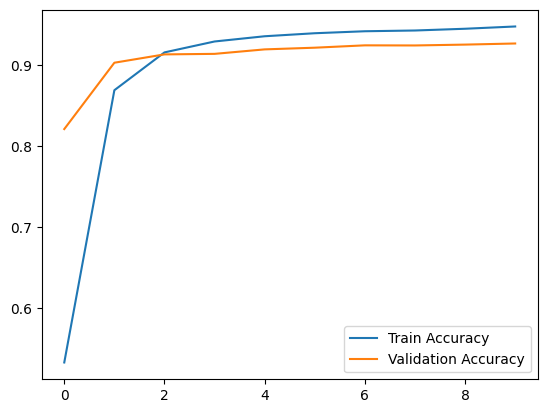

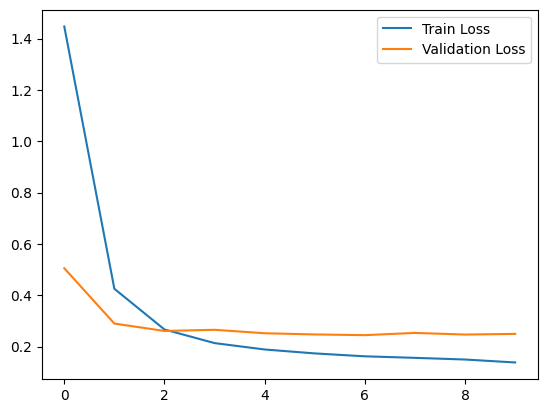

In [ ]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# **Evaluate Model Performance**

Tests the trained model on the test dataset and generates a classification report.

In [ ]:
print("Evaluating model...")
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Evaluating model...
Test Loss: 0.2446
Test Accuracy: 0.9220


In [ ]:
y_pred = model.predict(X_test, batch_size=256, verbose=1)
y_pred = y_pred.argmax(axis=1)

579/579 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step


In [ ]:
acc = accuracy_score(y_test, y_pred)


In [ ]:
acc

0.9220135135135135

# **Function for Language Prediction**

Predicts the language of a given sentence using the trained model.

In [ ]:
def predict_language(sentence, model, tokenizer, maxlen=MAX_LEN, num_to_label=num_to_label):
    seq = tokenizer.texts_to_sequences([sentence])
    padded_seq = pad_sequences(seq, padding='post', maxlen=maxlen, truncating='post')

    prediction = model.predict(padded_seq)
    predicted_class = np.argmax(prediction, axis=1)[0]

    predicted_language = num_to_label[predicted_class]

    return predicted_language

In [ ]:
print(classification_report(y_test, y_pred, target_names=[num_to_label[i] for i in range(len(num_to_label))]))

              precision    recall  f1-score   support

         ara       0.91      0.97      0.94      3920
         ber       0.80      0.87      0.83      4003
         bul       0.95      0.91      0.93      3957
         ces       0.91      0.95      0.93      3989
         cmn       0.06      0.01      0.02      4090
         dan       0.97      0.95      0.96      4007
         deu       1.00      0.99      0.99      3954
         ell       0.99      0.98      0.98      4007
         eng       0.98      0.98      0.98      4010
         epo       0.98      0.97      0.98      4030
         fin       0.97      0.94      0.96      4041
         fra       0.97      0.96      0.97      3979
         heb       0.98      0.97      0.97      3998
         hun       0.98      0.96      0.97      3978
         ina       0.96      0.96      0.96      3960
         ita       0.96      0.95      0.95      3910
         jpn       0.45      1.00      0.62      3998
         kab       0.86    

# **Load Language Dictionary and Test Predictions**


Uses a JSON file to map predicted language codes to human-readable language names.

In [ ]:
import json


def load_language_json(file_path):
    with open(file_path, 'r') as f:
        language_dict = json.load(f)
    return language_dict

In [ ]:
language_dict = load_language_json('/content/lan_to_language.json')

# **Test the model with example sentences in different languages.**

In [ ]:
sentence = "Ceci est un test."
predicted_language = predict_language(sentence, model, Token)
print(f"The predicted language is: {language_dict[predicted_language]}")
print(f"The True language is: french")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
The predicted language is: French
The True language is: french


In [ ]:
sentence = "This is a test."
predicted_language = predict_language(sentence, model, Token)
print(f"The predicted language is: {language_dict[predicted_language]}")
print(f"The True language is: English")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
The predicted language is: English
The True language is: English


In [ ]:
sentence = "Esto es una prueba."
predicted_language = predict_language(sentence, model, Token)
print(f"The predicted language is: {language_dict[predicted_language]}")
print(f"The True language is: Spanish")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
The predicted language is: Spanish
The True language is: Spanish


In [ ]:
sentence = "دعونا نحاول ذلك"
predicted_language = predict_language(sentence, model, Token)
print(f"The predicted language is: {language_dict[predicted_language]}")
print(f"The True language is: Arabic")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
The predicted language is: Arabic
The True language is: Arabic


In [ ]:
sentence = "試してみましょう"
predicted_language = predict_language(sentence, model, Token)
print(f"The predicted language is: {language_dict[predicted_language]}")
print(f"The True language is: Japanese")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
The predicted language is: Japanese
The True language is: Japanese


In [ ]:
sentence = "Vamos tentar"
predicted_language = predict_language(sentence, model, Token)
print(f"The predicted language is: {language_dict[predicted_language]}")
print(f"The True language is: Portuguese")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
The predicted language is: Portuguese
The True language is: Portuguese


In [ ]:
sentence = "בואו ננסה את זה"
predicted_language = predict_language(sentence, model, Token)
print(f"The predicted language is: {language_dict[predicted_language]}")
print(f"The True language is: Hebrew")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
The predicted language is: Hebrew
The True language is: Hebrew


In [ ]:
sentence = "Lass es uns versuchen"
predicted_language = predict_language(sentence, model, Token)
print(f"The predicted language is: {language_dict[predicted_language]}")
print(f"The True language is: German")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
The predicted language is: German
The True language is: German


In [ ]:
sentence = "mein Name ist Wasseem"
predicted_language = predict_language(sentence, model, Token)
print(f"The predicted language is: {language_dict[predicted_language]}")
print(f"The True language is: German")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
The predicted language is: German
The True language is: German


In [ ]:
sentence = "Это проверка."
predicted_language = predict_language(sentence, model, Token)
print(f"The predicted language is: {language_dict[predicted_language]}")
print(f"The True language is: Russian")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
The predicted language is: Russian
The True language is: Russian


In [ ]:
sentence = "在学球场"
predicted_language = predict_language(sentence, model, Token)
print(f"The predicted language is: {language_dict[predicted_language]}")
print(f"The True language is: Mandarin Chinese")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
The predicted language is: Japanese
The True language is: Mandarin Chinese


In [ ]:
sentence = "Hoi"
predicted_language = predict_language(sentence, model, Token)
print(f"The predicted language is: {language_dict[predicted_language]}")
print(f"The True language is: Dutch")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
The predicted language is: Dutch
The True language is: Dutch


In [ ]:
sentence = "Xin chào"
predicted_language = predict_language(sentence, model, Token)
print(f"The predicted language is: {language_dict[predicted_language]}")
print(f"The True language is: Vietnamese")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
The predicted language is: Vietnamese
The True language is: Vietnamese


In [ ]:
sentence = "Привіт"
predicted_language = predict_language(sentence, model, Token)
print(f"The predicted language is: {language_dict[predicted_language]}")
print(f"The True language is: Ukrainian")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
The predicted language is: Ukrainian
The True language is: Ukrainian


In [ ]:
sentence = "naDev"
predicted_language = predict_language(sentence, model, Token)
print(f"The predicted language is: {language_dict[predicted_language]}")
print(f"The True language is: Klingon")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
The predicted language is: Klingon
The True language is: Klingon


In [ ]:
sentence = "Tämä on kokeilu"
predicted_language = predict_language(sentence, model, Token)
print(f"The predicted language is: {language_dict[predicted_language]}")
print(f"The True language is: Finnish")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
The predicted language is: Finnish
The True language is: Finnish


In [ ]:
sentence = "Acesta este un test"
predicted_language = predict_language(sentence, model, Token)
print(f"The predicted language is: {language_dict[predicted_language]}")
print(f"The True language is: Romanian")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
The predicted language is: Romanian
The True language is: Romanian


In [ ]:
sentence = "Ова е тест"
predicted_language = predict_language(sentence, model, Token)
print(f"The predicted language is: {language_dict[predicted_language]}")
print(f"The True language is: Macedonian")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
The predicted language is: Macedonian
The True language is: Macedonian


In [ ]:
sentence = "Tohle je test"
predicted_language = predict_language(sentence, model, Token)
print(f"The predicted language is: {language_dict[predicted_language]}")
print(f"The True language is: Czech")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
The predicted language is: Czech
The True language is: Czech
